<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/master/examples/rnn/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import csv
import itertools
import operator
import numpy as np
import nltk
import sys
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
np.random.seed(2)

Download NLTK data

In [0]:
%%capture
nltk.download("book")

Upload deep_learning_sentences.txt file (or another file containing a list of sentences if you wish)

In [0]:
from google.colab import files
uploaded = files.upload()

Saving deep_learning_sentences.txt to deep_learning_sentences (1).txt


Add sentence start and end tags, convert to lower case and strip newlines

In [0]:
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"

In [0]:
with open('deep_learning_sentences.txt', 'r') as f:
  sentences = f.readlines()
sentences = ["%s %s %s" % (sentence_start_token, x.lstrip().rstrip('.\n').lower(), sentence_end_token) for x in sentences]

In [645]:
print("Parsed %d sentences." % (len(sentences)))
for i in range(0, 10):
  print("Example: %s" % sentences[i])

Parsed 7674 sentences.
Example: SENTENCE_START part ii  deep networks: modern  practices  166    this part of the book summarizes the state of modern deep learning as it is used to solve practical applications SENTENCE_END
Example: SENTENCE_START this part focuses only on those approaches that are essentially working tech- nologies that are already used heavily in industry SENTENCE_END
Example: SENTENCE_START by adding more layers and more units within a layer, a deep network can represent functions of increasing complexity SENTENCE_END
Example: SENTENCE_START most tasks that consist of mapping an input vector to an output vector, and that are easy for a person to do rapidly, can be accomplished via deep learning, given sufficiently large models and sufficiently large datasets of labeled training examples SENTENCE_END
Example: SENTENCE_START other tasks, that can not be described as associating one vector to another, or that are difficult enough that a person would require time to thin

Tokenize the sentences into words

In [0]:
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]

In [647]:
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))

Found 13509 unique words tokens.


In [0]:
vocab_size = 1000
unknown_token = 'UNKNOWN_TOKEN'

In [0]:
vocab = word_freq.most_common(vocab_size-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i, w in enumerate(index_to_word)])

Replace all words not in our vocabulary with the unknown token and discard sentences under min / over max number of words

In [0]:
max_sentence_length = 10

In [0]:
purged_sentences = []
for i, sent in enumerate(tokenized_sentences):
    purged_sentences.append([w if w in word_to_index else unknown_token for w in sent[0:max_sentence_length]])

In [652]:
print("Purged %d sentences." % (len(purged_sentences)))
for i in range(0, 10):
  print("Example: %s" % purged_sentences[i])

Purged 7674 sentences.
Example: ['SENTENCE_START', 'part', 'UNKNOWN_TOKEN', 'deep', 'networks', ':', 'modern', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'this']
Example: ['SENTENCE_START', 'this', 'part', 'UNKNOWN_TOKEN', 'only', 'on', 'those', 'approaches', 'that', 'are']
Example: ['SENTENCE_START', 'by', 'adding', 'more', 'layers', 'and', 'more', 'units', 'within', 'a']
Example: ['SENTENCE_START', 'most', 'tasks', 'that', 'UNKNOWN_TOKEN', 'of', 'mapping', 'an', 'input', 'vector']
Example: ['SENTENCE_START', 'other', 'tasks', ',', 'that', 'can', 'not', 'be', 'described', 'as']
Example: ['SENTENCE_START', 'this', 'part', 'of', 'the', 'book', 'UNKNOWN_TOKEN', 'the', 'UNKNOWN_TOKEN', 'parametric']
Example: ['SENTENCE_START', 'scaling', 'these', 'models', 'to', 'large', 'inputs', 'such', 'as', 'high']
Example: ['SENTENCE_START', 'we', 'introduce', 'the', 'convolutional', 'network', 'for', 'scaling', 'to', 'large']
Example: ['SENTENCE_START', 'UNKNOWN_TOKEN', ',', 'we', 'present', 'general', 'UNKN

Create the training data

In [0]:
X_train = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in purged_sentences])
Y_train = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in purged_sentences])

In [654]:
print("Example: ", X_train[2])

Example:  [  2  22 547  66 172  11  66  78 451]


In [0]:
def softmax(x):
    xt = np.exp(x - np.max(x))
    return xt / np.sum(xt)

In [0]:
class RNN:
    
  def __init__(self, word_dim, hidden_dim=100):
      # Assign instance variables
      self.word_dim = word_dim
      self.hidden_dim = hidden_dim
      # Randomly initialize the network parameters
      self.U = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (word_dim, hidden_dim))
      self.V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, word_dim))
      self.W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))
      self.b = np.zeros(hidden_dim)
      self.c = np.zeros(word_dim)

  def forward(self, x):
    # Do a forward pass for single example
    T = len(x)
    h = np.zeros((T , self.hidden_dim))
    o = np.zeros((T, self.word_dim))
    for t in range(T):
      # Note that we are indexing U by x[t]. This is the same as multiplying U with a one-hot vector.
      h[t] = self.U[x[t], :] + self.b
      if t > 1:
        h[t] += np.matmul(self.W.T, h[t-1])
      h[t] = np.tanh(h[t])
      o[t] = softmax(np.matmul(self.V.T, h[t]) + self.c)
    return (o, h)

  def backward(self, x, y, clip_value=None):
    #Do a backward pass for single example
    T = len(x)
    o, h = self.forward(x)
    # Accumulate the gradients in these variables
    dLdU = np.zeros(self.U.shape)
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    dLdb = np.zeros(self.b.shape)
    dLdc = np.zeros(self.c.shape)
    # dL/do
    delta_o = o
    delta_o[np.arange(len(y)), y] -= 1.
    # dL/dh
    delta_h = np.zeros((T, self.hidden_dim))
    for t in reversed(range(T)):
      delta_h[t] = np.matmul(self.V, delta_o[t, :])
      if t < T - 1:
        delta_h[t] += np.matmul(np.matmul(self.W, np.diag(1 - h[t+1]**2)), delta_h[t+1])
    # Accumulate gradients over time-steps
    for t in range(T):
      dLdc += delta_o[t, :]
      dLdb += (1 - h[t]**2) * delta_h[t, :]
      dLdV += np.outer(h[t, :], delta_o[t, :])
      if t > 0:
        dLdW += np.matmul(np.outer(h[t-1, :], delta_h[t, :]), np.diag(1 - h[t]**2))
      xm = np.zeros((self.word_dim))
      xm[x] = 1.
      dLdU += np.matmul(np.outer(xm, delta_h[t, :]), np.diag(1 - h[t]**2))
    if clip_value is not None:
      dLdb = np.clip(dLdb, -clip_value, clip_value)
      dLdc = np.clip(dLdc, -clip_value, clip_value)
      dLdV = np.clip(dLdV, -clip_value, clip_value)
      dLdW = np.clip(dLdW, -clip_value, clip_value)
      dLdU = np.clip(dLdU, -clip_value, clip_value)
    return (dLdU, dLdV, dLdW, dLdb, dLdc)

  def step(self, x, y, learning_rate=0.01):
    # Perform SGD step for single example
    dLdU, dLdV, dLdW, dLdb, dLdc  = self.backward(x, y)
    self.U -= learning_rate * dLdU
    self.V -= learning_rate * dLdV
    self.W -= learning_rate * dLdW
    self.b -= learning_rate * dLdb
    self.c -= learning_rate * dLdc

  def loss(self, x, y):
    # Per example loss
    o, h = self.forward(x)
    return - np.sum(o[np.arange(len(y)), y])

  def generate_sentence(self, max_length=20):
    # We start the sentence with the start token
    new_sentence = [word_to_index[sentence_start_token]]
    # Repeat until we get an end token or reach maximum sentence length
    while not new_sentence[-1] == word_to_index[sentence_end_token] and len(new_sentence) < max_length:
      o, h = self.forward(new_sentence)
      sampled_word = word_to_index[unknown_token]
      # We don't want to sample unknown words or sentence start
      while sampled_word == word_to_index[unknown_token] or sampled_word == word_to_index[sentence_start_token]:
          samples = np.random.multinomial(1, o[-1])
          sampled_word = np.argmax(samples)
      new_sentence.append(sampled_word)
    sentence_str = [index_to_word[x] for x in new_sentence]
    return sentence_str


In [0]:
model = RNN(vocab_size)

Generate random sentences

In [658]:
for i in range(10):
  print(model.generate_sentence())

['SENTENCE_START', 'scaling', 'contrast', 'over', 'itself', 'require', 'f', 'think', 'optimal', 'p̃', 'mixture', 'after', 'ways', 'intractable', 'exp', 'does', 'algebra', 'consists', 'systems', 'equations']
['SENTENCE_START', 'estimate', 'memory', 'most', 'parallel', 't−1', 'autoencoders', 'scaling', 'e', 'seen', 'times', 'about', 'using', 'energy', 'tasks', 'hyperparameter', 'conditional', 'term', 'exp', 'need']
['SENTENCE_START', 'challenge', 'before', 'finding', 'ways', 'easy', 'derivatives', 'sequence', 'our', 'directions', 'several', 'allows', 'directions', 'performance', 'representations', 'must', 'require', 'functions', 'used', 'validation']
['SENTENCE_START', 'introduced', 'present', 'name', 'pixel', 'its', 'coordinate', ':', 'arg', 'control', 'ai', 'q', 'goal', 'v|', 'simple', 'version', '\ue03e', 'are', 'tangent', 'fact']
['SENTENCE_START', 'matching', '}', 'analysis', 'such', 'described', 'significantly', 'unit', 'rather', 'sample', 'individual', 'time', 'performing', 'exact

In [0]:
num_epochs = 100
learning_rate = 0.01

Limit training examples to save time

In [0]:
X_train = X_train[0:1000]
Y_train = Y_train[0:1000]

In [661]:
loss_history = []
for epoch in range(num_epochs):
  loss = 0
  for i in range(len(X_train)):
    loss += model.loss(X_train[i], Y_train[i])
  loss = loss / len(X_train)
  print("Epoch {0} Loss {1}".format(epoch , loss))
  loss_history.append(loss)
  for i in range(len(X_train)):
    model.step(X_train[i], Y_train[i], learning_rate=learning_rate)
    


Epoch 0 Loss -0.009007153174984274
Epoch 1 Loss -0.22621631212436355
Epoch 2 Loss -0.2417146960054691
Epoch 3 Loss -0.25257743562278945
Epoch 4 Loss -0.26757642753375516
Epoch 5 Loss -0.2834518033854732
Epoch 6 Loss -0.2891189498302032
Epoch 7 Loss -0.2931158680695782
Epoch 8 Loss -0.2873345299200153
Epoch 9 Loss -0.3132902375848146
Epoch 10 Loss -0.16910739780216
Epoch 11 Loss -0.3203321229833319
Epoch 12 Loss -0.3330399808851384
Epoch 13 Loss -0.2989610747236169
Epoch 14 Loss -0.3101817726336136
Epoch 15 Loss -0.3415161706426696
Epoch 16 Loss -0.3447483656283422
Epoch 17 Loss -0.3048584133038364
Epoch 18 Loss -0.3239062588224977
Epoch 19 Loss -0.32779944311046
Epoch 20 Loss -0.35872126421348893
Epoch 21 Loss -0.34717512413355883
Epoch 22 Loss -0.36171855462979685
Epoch 23 Loss -0.38039523879093107
Epoch 24 Loss -0.40599025829124913
Epoch 25 Loss -0.3880447149850878
Epoch 26 Loss -0.39429926914585695
Epoch 27 Loss -0.3391592588675744
Epoch 28 Loss -0.40349988707521667
Epoch 29 Loss -0

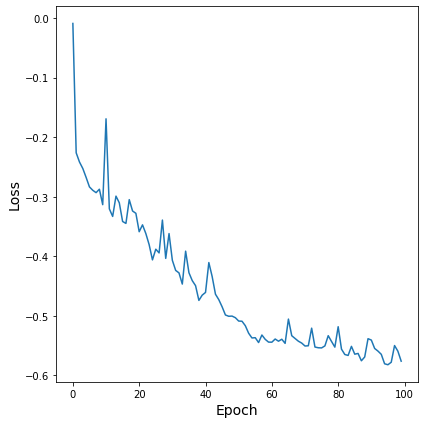

In [662]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(loss_history[:])
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
plt.tight_layout()
plt.show()

In [663]:
for i in range(10):
  print(model.generate_sentence())

['SENTENCE_START', 'the', 'penalty', 'the', 'of', 'softmax', 'terms', 'a', 'good', 'with', 'common', 'the', 'gradient', 'the', 'we', 'hidden', 'with', 'a', 'ensemble', 'the']
['SENTENCE_START', 'the', '“', 'equations', 'computing', 'a', 'is', ',', 'most', ')', 'in', 'each', 'significantly', 'j', 'a', 'right', 'when', 'possible', 'a', 'the']
['SENTENCE_START', 'perform', 'this', ',', 'we', 'the', 'new', 'an', 'problem', 'the', 'penalty', 'use', 'softmax', 'al.', 'possible', 'based', 'with', 'is', 'the', 'terms']
['SENTENCE_START', 'in', 'other', 'a', 'learning', 'noise', 'a', ',', 'we', 'can', 'this', 'dataset', 'a', 'an', '8', 'φ', 'a', 'classifier', 'a', 'covariance']
['SENTENCE_START', 'the', 'model', 'process', 'is', 'architecture', 'output', 'for', 'of', 'to', 'by', 'use', 'a', 'decay', 'j', ')', 'images', 'know', 'if', 'terms']
['SENTENCE_START', 'a', 'model', 'cost', 'the', 'ideas', 'to', 'many', 'loss', 'as', 'representing', 'so', 'a', 'one', 'norm', '2009', 'been', 'by', 'of', 